In [1]:
import glob 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from fastpip import pip
from scipy.signal import savgol_filter    
import scipy
from scipy.optimize import curve_fit

# Preliminar analysis

In this script, I will try to put everything togheder to compute the transition among state ABAB to AAAA obtained by changing the magnetic interaction among particles from purely repulsive to purely attractive. How the magnetic field change in each experiment is explained and computed in script Setting_MagneticField.ipynb. 

In this preliminar analysis I will analyze Experiment 0. This experiment correspond with a purelly attractive interaction. 

To do:

    1. Choose interaction cut off, to separate "train" of particles. 
        Solved: Instead of trains of particles I will analyze pairs of particles.
    2. Develop algorith to define magnetization.
    3. Choose criterium for "density" in trains, the particle-particle distances are not constant.
        Solved: I will choose the mean distance among particles. 
    

## 1. 
The interaction cut off will be obtained from the magnetic susceptibility calculation. At 21 mT the particles reach a maximum distance of approx 70 $\mu m$. The size of the particles is 18.82 $\mu m$.

  <span style="color:red">To do: Take an image of scale bar with 10x Objective!</span>

## 2. 
To do that I need to have the tracking trajectories

    Solved: Trajectories obtained in Script Automatic_Tracking

In [2]:
directory = "/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/Data/EXP0"

filenames = [file for file in glob.glob(
    os.path.join(directory,('*41_20_tracking.dat')))]
filenames

['/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/Data/EXP0/EXP0_2023_03_21_16_41_20_tracking.dat']

In [3]:
for file_no, filename in enumerate(filenames[0:]):

    trj = pd.read_csv(filename[:filename.find("_tracking.dat")]+"_tracking.dat", index_col = [0,1], sep ="\t")

In [4]:
name = 'EXP0_2023_03_21_16_51_57'

In [5]:
trj = pd.read_csv(os.path.join(directory,(name+'_tracking.dat')),sep = '\t', usecols = ['frame','particle','x','y'])

In [6]:
n_of_particles = len(trj['particle'].unique())
n_of_particles, trj['particle'].unique()

(5, array([  3,   7,  58, 618, 702]))

In [7]:
def y_bifurcation_position(df):
    """In this function I will locate the bifurcation position"""
    
    y, x , _ = plt.hist(df['y'], bins = 40, )
    y_bif = x[np.argmax(y)]
    
    return y_bif, df

def x_bifurcation_position(df, y_bif):
    """In this function I will find the x value of the bifurcation"""
    
    particles = df.particle.unique()
    points = []
    for i in particles:
        
        particle = trj.query('particle =='+str(i))

        data = np.stack((particle.x, particle.y), axis=-1)
        points.append(pip(data,4))
    
    points_ar = np.array(points)
    new_df = points_ar.reshape((len(points_ar[0])*len(points_ar),2))
    df = pd.DataFrame(data=new_df, columns = ['x', 'y'])
    y_bifurcation_plus = y_bif+10
    y_bifurcation_minus = y_bif-10

    df_filtered = df.query('y < '+str(y_bifurcation_plus)+' & y > '+str(y_bifurcation_minus))
    x_bif = df_filtered.x.min()
    return x_bif

In [8]:
def improve_x_and_y_bif(trj, x_bif, y_bif):
    
    """This function will improve the first estimation of x_bif and y_bif
        and will return a fit of the channel"""
    x_int = []
    y_int = []
    fit=[]
    for i in range(0,len(trj['particle'].unique())):
        particle = trj['particle'].unique()[i] # Select a particle trj

        x1 = trj.query('particle == '+str(particle)+' & x < '+str(x_bif)).x
        y1 = trj.query('particle == '+str(particle)+' & x < '+str(x_bif)).y

        x2 = trj.query('particle == '+str(particle)+' & x > '+str(x_bif)).x
        y2 = trj.query('particle == '+str(particle)+' & x > '+str(x_bif)).y

        fit1 = np.poly1d(np.polyfit(x1, y1, 1)) # fit biburcation
        fit2 = np.poly1d(np.polyfit(x2, y2, 1)) # fit channel
        
        fit.append(np.poly1d(np.polyfit(x2, y2, 1))) # fit channel

        # compute intersection among fits
        x_int.append((fit2[0]-fit1[0])/(fit1[1]-fit2[1]))
        y_int.append(fit1[1]*x_int[i]+fit1[0])
        
    x_int = np.mean(x_int)
    y_int = np.mean(y_int)
    
    return x_int, y_int, fit

In [9]:
def up_or_down(df, y_bif):
    
    """This function indicates which channel the particle has choose.
    The information is stored in the column bif."""
    
    df_trj = df[df.duplicated(subset=['frame'], keep=False)]  # Keep only frames that have more than one particle

    df_trj['bif'] = np.NaN
    for p,df in df_trj.groupby('particle'):
        
        if df.iloc[-1].y > y_bif:
            df_trj.loc[trj.particle==p,'bif'] = 'UP'
        else:
            df_trj.loc[trj.particle==p,'bif']= 'DOWN'
        
    return df_trj

In [10]:
def create_pairs(df, frame):
    """This function generates pair of particles. A pair of particle is defined 
    when one particles enter to the channel after the other. So, consecutive
    particles will be part of a pair.
    This function works for one frame"""

    df_f = df.query('frame == '+str(frame)) # First select a frame

    df_order = df_f.sort_values(by = ['x'])       # Order the x column in ascendent values, 
                                                  # this will be the order of particles entering the chanel. 
    new_df = []
    keys = []
    p1 = []
    p2 = []
    j = 2
    
    for i in range(0, len(df_order)-1):       
        
        p1.append(df_order.iloc[i:j].particle.values[0])
        p1.append(df_order.iloc[i:j].particle.values[0])


        p2.append(df_order.iloc[i:j].particle.values[1])
        p2.append(df_order.iloc[i:j].particle.values[1])

        new_df.append(df_order.iloc[i:j])  # Join consecutive rows, generating pairs
      

        keys.append(i)
        j = j +1
    p1 = pd.DataFrame({'p1':p1})
    p2 = pd.DataFrame({'p2':p2})

    final_df = pd.concat(new_df, keys = keys, names = ['pairs','index'])
    pairs = pd.concat([p1,p2], axis = 1)
    
    final_df['p1'] = pairs['p1'].values
    final_df['p2'] = pairs['p2'].values
    
    return final_df

In [11]:
def magnetization(df, frame):
    
    """Magnetization is equal to 1 when the 2 particles choose the same channel
        Magnetization is equal to 0 when the particles choose different channels"""
    
    df = df.query('frame == '+str(frame))
    magnetization = []
    for ind,group in df.groupby(['pairs']):

        if len(np.unique(group.bif)) == 2:

            magnetization.append(0)
            magnetization.append(0)

        else:

            magnetization.append(1) 
            magnetization.append(1)


    df['magnetization'] = magnetization
    return df

In [12]:
def d(df , pix = float, um = float):  
    "With this function I will compute the distance among particles."
    
    df['distance'] = np.NaN # Crate new column
    dx = []
    dy = []
    grouped = df.groupby(['frame','pairs'])
    for name,group in grouped:
        
        dx.append((np.sqrt((group.x.diff(periods=-1).values)**2)[0])*(um/pix))
        dx.append((np.sqrt((group.x.diff(periods=-1).values)**2)[0])*(um/pix))
    
        dy.append((np.sqrt((group.y.diff(periods=-1).values)**2)[0])*(um/pix))
        dy.append((np.sqrt((group.y.diff(periods=-1).values)**2)[0])*(um/pix))
    
    df['dx'] = dx
    df['dy'] = dy
    
    return df

In [13]:
def check_analysis(trj_initial,last_df_analyzed):
    
    n_of_particles = len(trj_initial['particle'].unique())
    n_of_pairs = len(last_df_analyzed.groupby(['p1','p2']).size())
    
    if (n_of_particles == n_of_pairs+1):
        
        print("Analysis succesfully performed of video")
    else:
        print("Something was wrong during tracking or analysis. We detect N partcles and not N-1 pairs")

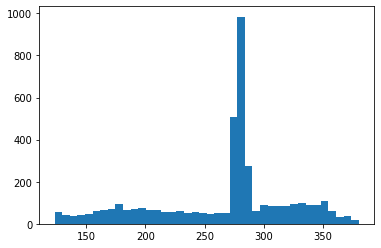

In [14]:
y_bif, df = y_bifurcation_position(trj)
x_bif = x_bifurcation_position(trj, y_bif)

In [15]:
x_bif, y_bif, fit = improve_x_and_y_bif(trj, x_bif, y_bif)


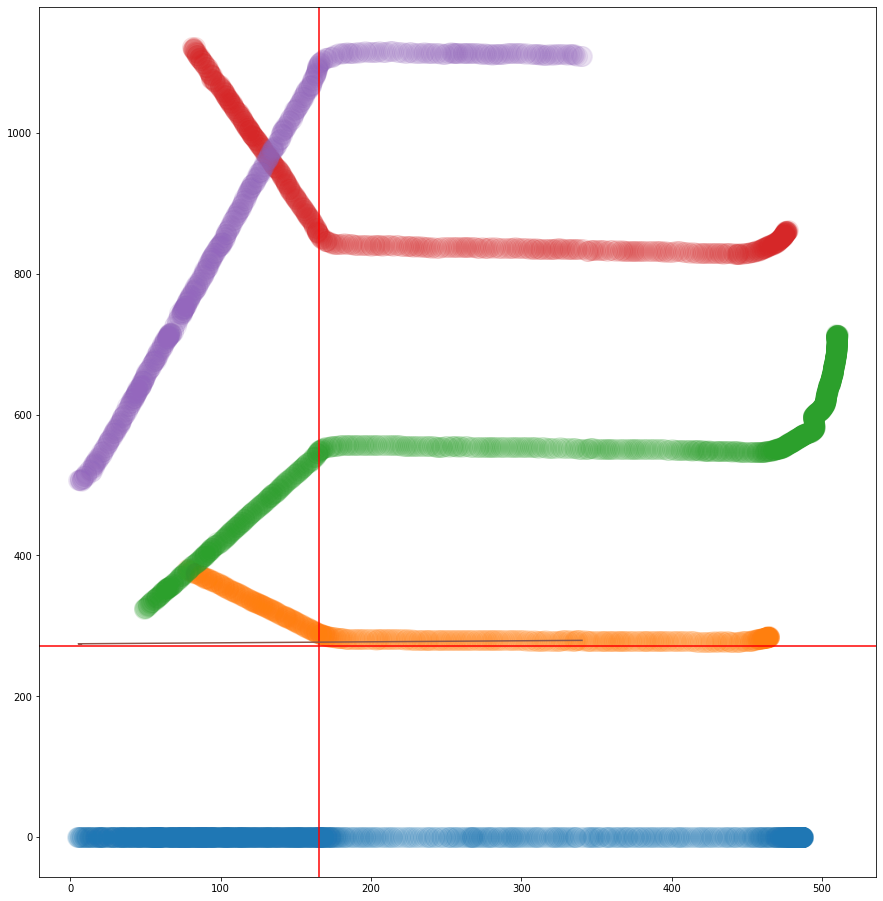

In [16]:
fig, ax = plt.subplots(1,1,figsize=(15,16))
j = 0
for p,trj_p in trj.groupby("particle"):
    ax.plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    j = j+1
plt.axhline(y=y_bif, color='r', linestyle='-')
plt.axvline(x=x_bif, color='r', linestyle='-')
plt.plot(trj_p.x, trj_p.x*fit[0][1]+fit[0][0])

In [17]:
fit

[poly1d([1.44838810e-02, 2.74579604e+02]),
 poly1d([1.02414325e-03, 2.79805321e+02]),
 poly1d([1.93884883e-01, 2.16433010e+02]),
 poly1d([6.98692215e-03, 2.77052123e+02]),
 poly1d([-5.54155805e-03,  2.79659409e+02])]

In [18]:
inter = up_or_down(trj,y_bif)

/home/carolina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/carolina/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


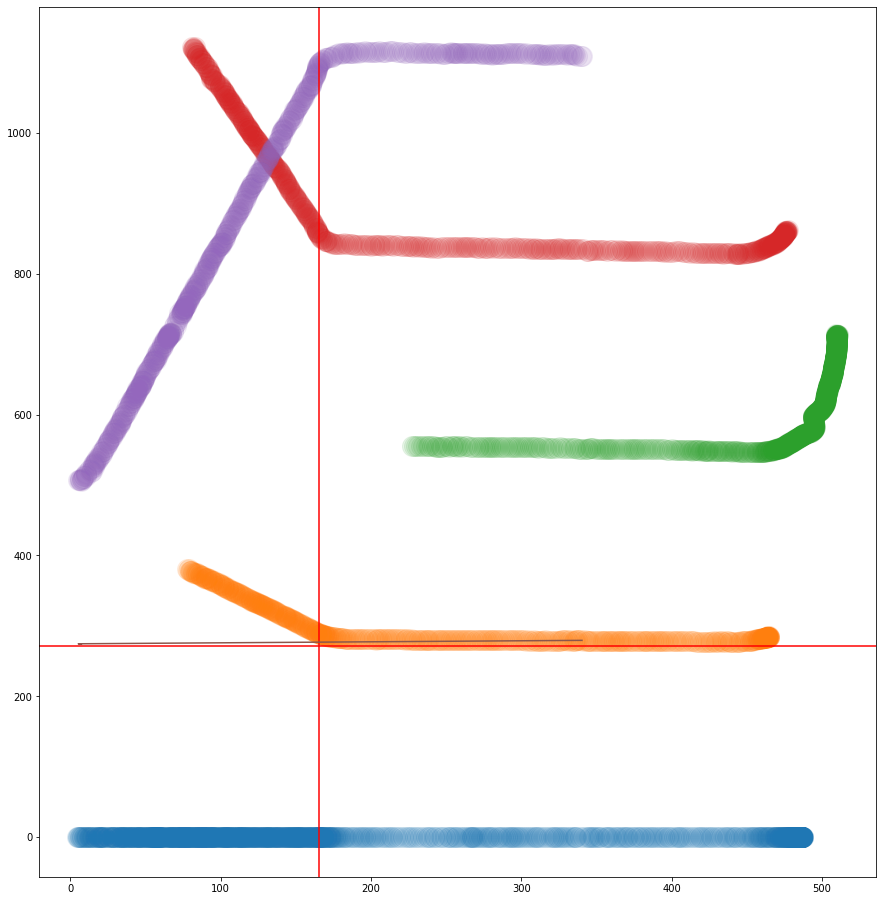

In [19]:
fig, ax = plt.subplots(1,1,figsize=(15,16))
j = 0
for p,trj_p in inter.groupby("particle"):
    
    ax.plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    j = j+1
plt.axhline(y=y_bif, color='r', linestyle='-')
plt.axvline(x=x_bif, color='r', linestyle='-')
plt.plot(trj_p.x, trj_p.x*fit[0][1]+fit[0][0])

In [20]:
len(trj), len(inter)

(4122, 3766)

In [21]:
df_x = inter.query('x > '+str(x_bif))
    
df_d = df_x[df_x.duplicated(subset=['frame'], keep=False)]

In [22]:
len(df_x), len(df_d)

(2223, 1795)

3
7
58
618
702


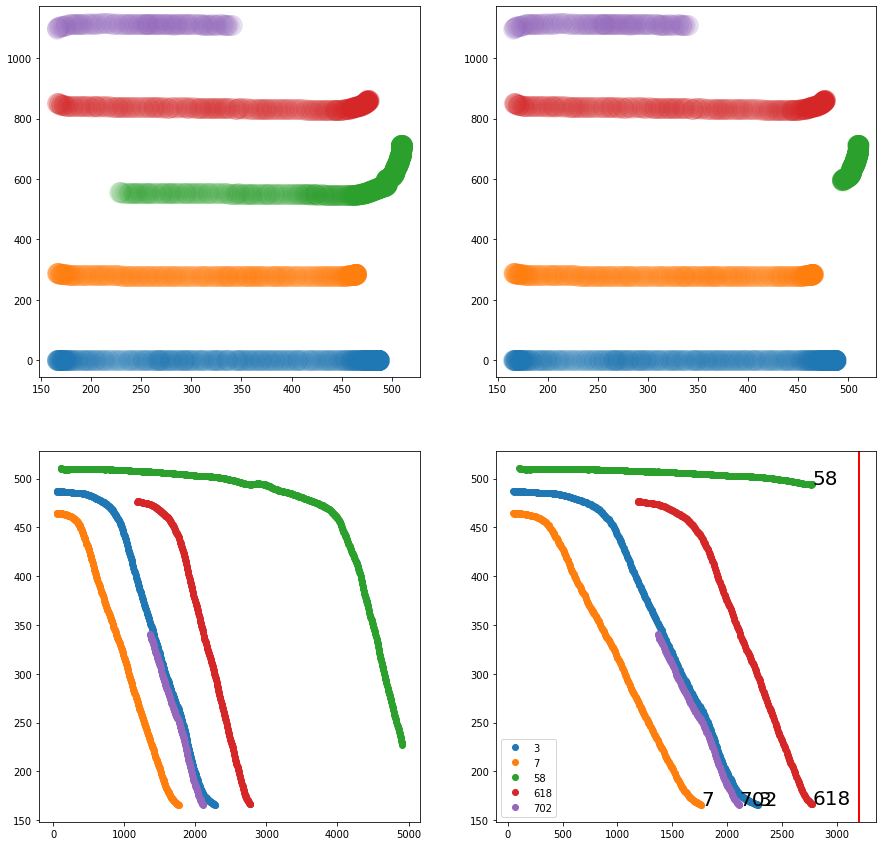

In [23]:
fig, (ax0,ax1) = plt.subplots(2,2, figsize = (15,15))

j = 0
for p,trj_p in df_x.groupby("particle"):
    
    ax0[0].plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    ax1[0].plot(trj_p.frame, trj_p.x, 'o')
    j = j+1
    
j = 0
for p,trj_p in df_d.groupby("particle"):
    
    ax0[1].plot(trj_p.x, trj_p.y*j, 'o', alpha = 0.1, markersize = 20)
    ax1[1].plot(trj_p.frame, trj_p.x, 'o', label = str(p))
    ax1[1].text(trj_p.frame.max(), trj_p.x.min() , s = str(p), size = 20)
    ax1[1].axvline(x=3200, color='r', linestyle='-')
    ax1[1].legend()


    print(str(p))

    

    j = j+1

In [26]:
%%time
df_last = []

df_x = inter.query('x > '+str(x_bif)+'& x < 450')
    
df_d = df_x[df_x.duplicated(subset=['frame'], keep=False)]

for frame in df_d['frame'].unique(): # Do analysis frame by frame
    
    pairs = create_pairs(df_d, frame)
    mag = magnetization(pairs, frame)
    df_last.append(d(mag, 1, 1)) # I need to introduce the pix/um conversion.

    
last = pd.concat(df_last)    

CPU times: user 2.76 s, sys: 3.87 ms, total: 2.76 s
Wall time: 2.76 s


In [27]:
check_analysis(trj, last)

Analysis succesfully performed of video


In [28]:
n_of_particles

5

In [29]:
last.groupby(['p1','p2']).size()

p1   p2 
3    618    234
7    3      158
     702    162
702  3      300
dtype: int64

In [29]:
last

frame  particle           y           x   bif   p1  p2  \
pairs index                                                           
0     1055    1180         3  275.599890  365.330406  DOWN    3  36   
      1056    1180        36  272.530241  449.758076  DOWN    3  36   
      1062    1185         3  275.623038  363.756726  DOWN    3  36   
      1061    1185        36  272.368111  448.638042  DOWN    3  36   
      1067    1190         3  275.783303  362.765768  DOWN    3  36   
...            ...       ...         ...         ...   ...  ...  ..   
      3078    3205        10  277.493879  303.662096  DOWN  125  10   
      3083    3210       125  282.517082  177.574638    UP  125  10   
      3084    3210        10  277.258539  302.306214  DOWN  125  10   
      3088    3215       125  282.654101  177.099216    UP  125  10   
      3089    3215        10  277.450351  300.563673  DOWN  125  10   

             magnetization    distance  
pairs index                             
0     1055               1   84.483455  
      1056               1   84.483455  
      1062               1   84.943700  
      1061               1   84.943700  
      1067               1   85.715641  
...                    ...         ...  
      3078               0  125.424356  
      3083               0  124.842374  
      3084               0  124.842374  
      3088               0  123.574072  
      3089               0  123.574072  

[984 rows x 9 columns]

# Next step

Now I need to compute the main distance in the channel for pairs of particles and associate a magnetization value to this pair.

In [30]:
def distance_and_magnetization(df, x_bif):
    
    output = df.groupby(['p1','p2']).mean()
    output['dx_err'] = df.groupby(['p1','p2']).dx.std()/np.sqrt(df.groupby(['p1','p2']).count()['dx'])
    output['dy_err'] = df.groupby(['p1','p2']).dy.std()/np.sqrt(df.groupby(['p1','p2']).count()['dy'])

    
    return output

In [31]:
output = distance_and_magnetization(last,x_bif)
output

frame  particle           y           x  magnetization  distance  \
p1  p2                                                                       
3   618  1990.0     310.5  278.398915  293.134611            0.0       NaN   
7   3    1165.0       5.0  278.133541  338.777279            0.0       NaN   
    702  1565.0     354.5  280.450692  243.010546            0.0       NaN   
702 3    1737.5     352.5  278.466767  258.486330            1.0       NaN   

                 dx        dy    dx_err    dy_err  
p1  p2                                             
3   618  167.978406  2.363209  0.875782  0.041933  
7   3    123.662670  3.229907  0.155059  0.030865  
    702  101.604358  4.819561  0.515325  0.187470  
702 3     11.868089  0.949514  0.029344  0.074283

In [32]:
output.to_csv('magnetization_'+name+'.dat', sep = '\t')